* EDA for formulation  

# Import Libraries and Data

In [1]:
import numpy as np
import pandas as pd
pd.get_option("display.max_columns")
pd.set_option('display.max_columns', 300)
pd.get_option("display.max_rows")
pd.set_option('display.max_rows', 300)

import matplotlib.pyplot as plt
%matplotlib inline

import os
from os.path import join as opj
import gc

INPUT_PATH = '../../input/feedback-prize-effectiveness/'

LABEL = 'discourse_effectiveness'

In [2]:
train_df = pd.read_csv(opj(INPUT_PATH, 'train.csv'))
test_df = pd.read_csv(opj(INPUT_PATH, 'test.csv'))
sub_df = pd.read_csv(opj(INPUT_PATH, 'sample_submission.csv'))

print('train_df.shape = ', train_df.shape)
print('test_df.shape = ', test_df.shape)
print('sub_df.shape = ', sub_df.shape)

train_df.shape =  (36765, 5)
test_df.shape =  (10, 4)
sub_df.shape =  (10, 4)


# EDA

In [3]:
train_df.head()

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate


In [4]:
unique_ids = np.array(sorted(train_df['essay_id'].unique()))

In [5]:
idx = 0
train_df[train_df['essay_id']==unique_ids[idx]]

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
14340,fe6dfbd53216,00066EA9880D,Driverless cars are exaclty what you would exp...,Lead,Adequate
14341,ca9e1b60c9fb,00066EA9880D,The developement of these cars should be stopp...,Position,Effective
14342,6cf2157f4f19,00066EA9880D,the driver will be alerted when they will need...,Claim,Effective
14343,d920880f4341,00066EA9880D,This is such a dangerous thing because we all ...,Evidence,Effective
14344,7d52c3216a0e,00066EA9880D,Another thing that can go wrong with these car...,Claim,Effective
14345,30930de50889,00066EA9880D,Every person with any kind of technological de...,Evidence,Effective
14346,d16ff143cb0b,00066EA9880D,who to blame for the wreck if there were possi...,Claim,Effective
14347,cb665a65fb75,00066EA9880D,Should the manufacturer of the car be blamed o...,Evidence,Effective
14348,3e75ef7e0262,00066EA9880D,With all these things that could possibly go w...,Concluding Statement,Adequate


In [6]:
train_df[LABEL].value_counts()

Adequate       20977
Effective       9326
Ineffective     6462
Name: discourse_effectiveness, dtype: int64

In [7]:
train_df['discourse_type'].value_counts()

Evidence                12105
Claim                   11977
Position                 4024
Concluding Statement     3351
Lead                     2291
Counterclaim             1773
Rebuttal                 1244
Name: discourse_type, dtype: int64

In [8]:
from tqdm import tqdm

relation_mapper = {
    'Lead': ['Position',''],
    'Position': ['Lead',''],
    'Claim': ['Position',''],
    'Counterclaim': ['Position',''],
    'Rebuttal': ['Counterclaim',''],
    'Evidence': ['Claim',''],
    'Concluding Statement': ['Claim', 'Evidence']
}

def generate_text(df):
    df['related_type_0'] = df['discourse_type'].apply(lambda x:relation_mapper[x][0])
    df['related_type_1'] = df['discourse_type'].apply(lambda x:relation_mapper[x][1])

    data_df = []
    for unique_id in tqdm(unique_ids):
        tmp_df = train_df[train_df['essay_id']==unique_id].reset_index(drop=True)

        discourse_type_df = tmp_df.groupby('discourse_type')['discourse_id'].apply(list).reset_index()
        discourse_type_df_0 = discourse_type_df.rename(columns={'discourse_type':'related_type_0','discourse_id':'related_id_0'})
        tmp_df = tmp_df.merge(discourse_type_df_0, on='related_type_0', how='left')

        discourse_type_df_1 = discourse_type_df.rename(columns={'discourse_type':'related_type_1','discourse_id':'related_id_1'})
        tmp_df = tmp_df.merge(discourse_type_df_1, on='related_type_1', how='left').fillna('')


        for idx in range(len(tmp_df)):
            discourse_type = tmp_df.loc[idx, 'discourse_type']
            discourse_text = tmp_df.loc[idx, 'discourse_text']

            related_type_0 = tmp_df.loc[idx, 'related_type_0']
            related_id_0   = tmp_df.loc[idx, 'related_id_0']
            related_text_list_0 = []
            for i,disc_id in enumerate(related_id_0):
                related_text_list_0.append(f'[{related_type_0.upper()}]' + tmp_df.loc[tmp_df['discourse_id']==disc_id, 'discourse_text'].values[0])
            related_text_0 = ' '.join(related_text_list_0)
            text = f'[{discourse_type.upper()}]{discourse_text}[SEP]{related_text_0}'

            related_type_1 = tmp_df.loc[idx, 'related_type_1']
            if related_type_1!='':
                related_id_1  = tmp_df.loc[idx, 'related_id_1']
                related_text_list_1 = []
                for i,disc_id in enumerate(related_id_1):
                    related_text_list_1.append(f'[{related_type_1.upper()}]' + tmp_df.loc[tmp_df['discourse_id']==disc_id, 'discourse_text'].values[0])
                related_text_1 = ' '.join(related_text_list_1)
                text += f'{related_text_1}'

            tmp_df.loc[idx,'text'] = text
            tmp_df.loc[idx,'discourse_text_2'] = f'[{discourse_type.upper()}]{discourse_text}'
        data_df.append(tmp_df)

    data_df = pd.concat(data_df).reset_index(drop=True)
    return data_df

In [9]:
import os
os.makedirs('./result', exist_ok=True)

In [10]:
data_df = generate_text(train_df)
data_df.to_csv('./result/preprocessed_train.csv', index=False)
data_df.head()

100%|██████████| 4191/4191 [01:04<00:00, 64.74it/s]


,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,related_type_0,related_type_1,related_id_0,related_id_1,text,discourse_text_2
0,fe6dfbd53216,00066EA9880D,Driverless cars are exaclty what you would exp...,Lead,Adequate,Position,,[ca9e1b60c9fb],,[LEAD]Driverless cars are exaclty what you wou...,[LEAD]Driverless cars are exaclty what you wou...
1,ca9e1b60c9fb,00066EA9880D,The developement of these cars should be stopp...,Position,Effective,Lead,,[fe6dfbd53216],,[POSITION]The developement of these cars shoul...,[POSITION]The developement of these cars shoul...
2,6cf2157f4f19,00066EA9880D,the driver will be alerted when they will need...,Claim,Effective,Position,,[ca9e1b60c9fb],,[CLAIM]the driver will be alerted when they wi...,[CLAIM]the driver will be alerted when they wi...
3,d920880f4341,00066EA9880D,This is such a dangerous thing because we all ...,Evidence,Effective,Claim,,"[6cf2157f4f19, 7d52c3216a0e, d16ff143cb0b]",,[EVIDENCE]This is such a dangerous thing becau...,[EVIDENCE]This is such a dangerous thing becau...
4,7d52c3216a0e,00066EA9880D,Another thing that can go wrong with these car...,Claim,Effective,Position,,[ca9e1b60c9fb],,[CLAIM]Another thing that can go wrong with th...,[CLAIM]Another thing that can go wrong with th...


In [11]:
data_df.shape

(36765, 11)

In [12]:
from transformers.models.deberta_v2 import DebertaV2TokenizerFast   

model_name = 'microsoft/deberta-v3-base'
tokenizer = DebertaV2TokenizerFast.from_pretrained(model_name, trim_offsets=False)      
special_tokens_dict = {'additional_special_tokens': ['\r\n'] + [f'[{s.upper()}]' for s in list(relation_mapper.keys())]}
_ = tokenizer.add_special_tokens(special_tokens_dict)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [13]:
token_length_list = []
for text in tqdm(data_df['text'].values):
    token_length_list.append( len(tokenizer.tokenize(text, add_special_tokens=True)) )

100%|██████████| 36765/36765 [00:12<00:00, 2901.99it/s]


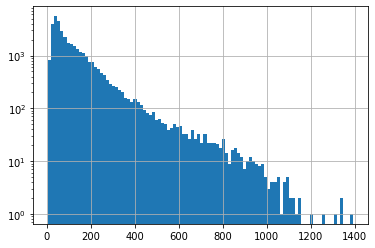

In [14]:
plt.hist(token_length_list, bins=100)
plt.yscale('log')
plt.grid();